In [2]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt

In [147]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 10, n_redundant=3, n_informative=5, n_classes=5)

#### Statistical tests

**`SelectKBest`** transforms the data based on relationship between columns and y variable.

It takes a function for statistical test `score_func` and the number of features to keep `k`. 
Score function varies, but the general principle is to get as input `X` and `y`, and return `scores` for each column. 
For classification task there are 3 default functions: 
* **chi2** applies Chi-Squared test for each column and class. Importantly, accepts only non-negative features, suited for categorical data such as booleans and frequencies. Not used with continious data. 
* **f_classif** Computes ANOVA F-value test. Default. 
* **mutual_info_classif** Estimate mutual information for a discrete target variable.The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

For regression, you have also `f_regression`, `mutual_info_regression`.

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In [144]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(precision=4, suppress=True)


scaler = MinMaxScaler()
Xtr = scaler.fit_transform(X)

# Using chi-squared test
selector = SelectKBest(score_func=chi2)
fit = selector.fit(Xtr, y)
print 'Chi-Squared:', sorted(enumerate(fit.scores_), key=lambda (ix, x): x, reverse=True)[:4]

# Using Anova F-test
selector = SelectKBest(score_func=f_classif)
fit = selector.fit(Xtr, y)
print 'Anova:', sorted(enumerate(fit.scores_), key=lambda (ix, x): x, reverse=True)[:4]

# Using mutual info criteria
selector = SelectKBest(score_func=mutual_info_classif)
fit = selector.fit(Xtr, y)
print 'Mutual Info:', sorted(enumerate(fit.scores_), key=lambda (ix, x): x, reverse=True)[:4]

Chi-Squared: [(13, 11.132318964498543), (14, 10.283135830918578), (0, 9.5806654381196967), (17, 9.0684314014131129)]
Anova: [(0, 76.310572532677071), (13, 70.887794689803201), (18, 59.28976658477373), (14, 58.061243403984086)]
Mutual Info: [(16, 0.16046842301424835), (0, 0.1545718791073214), (18, 0.14041175607996426), (10, 0.13197219841729257)]


#### Recursive feature elimination

For `RFE` a model trained on a full set of features, then eliminate features with the least absolute values, until necessary number of features is kept. `RFECV` can determine a number of informative features beased on cross-validation. 

In [75]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
rfe = RFE(lr, n_features_to_select=4)

fit = rfe.fit(X, y)
print 'RFE number of features:', fit.n_features_
print 'RFE:', sorted(enumerate(fit.ranking_), key = lambda (ix, x): x)

rfecv = RFECV(lr)
fit = rfecv.fit(X, y)
print 'Optimal number of features', fit.n_features_
print 'RFECV:', sorted(enumerate(fit.ranking_), key = lambda (ix, x): x)

RFE number of features: 4
RFE: [(0, 1), (3, 1), (4, 1), (9, 1), (7, 2), (2, 3), (5, 4), (1, 5), (8, 6), (6, 7)]
Optimal number of features 5
RFECV: [(0, 1), (3, 1), (4, 1), (7, 1), (9, 1), (2, 2), (5, 3), (1, 4), (8, 5), (6, 6)]


#### L1-norm based reduction

L1-norm can reduce the number of feature by assigning zero weights. Importantly, with SVMs and logistic-regression, the parameter C controls the sparsity: the smaller C the fewer features selected. With Lasso, the higher the alpha parameter, the fewer features selected.

In [130]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

X, y = make_classification(1000, 9, n_redundant=3, n_informative=5, n_classes=3)

svm = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X, y)
model = SelectFromModel(svm, prefit=True)
Xnew = model.transform(X)
print X.shape, Xnew.shape

sgd = SGDClassifier(alpha=0.1, penalty='l1').fit(X, y)
model = SelectFromModel(sgd, prefit=True)
Xtr = model.transform(X)
print X.shape, Xtr.shape

print svm.coef_
print 
print sgd.coef_

(1000L, 9L) (1000L, 8L)
(1000L, 9L) (1000L, 5L)
[[-0.4941  0.      0.      0.      0.1193  0.      0.      0.0644  0.    ]
 [ 0.1625 -0.1297  0.0361  0.      0.     -0.0087 -0.0192  0.      0.    ]
 [ 0.1187  0.1428  0.     -0.0448  0.      0.      0.     -0.1788  0.    ]]

[[-0.8032  0.      0.      0.      0.1137  0.      0.0236  0.1805  0.    ]
 [ 0.1846 -0.2059  0.      0.      0.      0.     -0.0673  0.      0.    ]
 [ 0.1748  0.2322  0.      0.      0.      0.      0.     -0.227   0.    ]]


#### Tree-based reduction

Tree based methods outputs feature importances based on heuristic. It is sometimes called "gini importance" or "mean decrease impurity" and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble. Reference: Breiman, Friedman, "Classification and regression trees", 1984.

In [138]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_classification(1000, 20, n_redundant=10, n_informative=5, n_classes=5)

rf = RandomForestClassifier().fit(X, y)
print np.mean(rf.feature_importances_), rf.feature_importances_

model = SelectFromModel(rf, prefit=True)
Xtr = model.transform(X)
print X.shape, Xtr.shape


0.05 [ 0.055   0.0536  0.0484  0.0268  0.0278  0.0724  0.0622  0.0186  0.0506
  0.0287  0.0716  0.0186  0.0404  0.0784  0.0439  0.0508  0.0832  0.065
  0.0549  0.0491]
(1000L, 20L) (1000L, 11L)


Feature ranking:
1. feature 16 (0.083215)
2. feature 13 (0.078395)
3. feature 5 (0.072412)
4. feature 10 (0.071594)
5. feature 17 (0.065026)
6. feature 6 (0.062241)
7. feature 0 (0.054957)
8. feature 18 (0.054894)
9. feature 1 (0.053565)
10. feature 15 (0.050794)
11. feature 8 (0.050568)
12. feature 19 (0.049138)
13. feature 2 (0.048430)
14. feature 14 (0.043882)
15. feature 12 (0.040427)
16. feature 9 (0.028708)
17. feature 4 (0.027810)
18. feature 3 (0.026777)
19. feature 11 (0.018585)
20. feature 7 (0.018581)


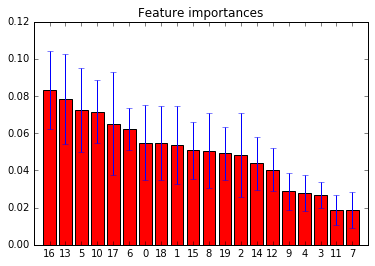

In [139]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()